In [43]:
# system & address
import os
from zipfile import ZipFile

# data
import numpy as np
from imageio import imread
from skimage.transform import resize
import cv2

import tensorflow as tf

# modeling
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, LeakyReLU, Add, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

# visualization
import matplotlib.pyplot as plt

### model

In [44]:
class DataLoader:
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = [f for f in data.namelist() if f.startswith(data_type)]

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            img = resize(img, self.img_res)
            if not is_testing:
                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            imgs.append(img)

        imgs = np.array(imgs) / 127.5 - 1.0
        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path_A = [f for f in data.namelist() if f.startswith(data_type + "0")]
        path_B = [f for f in data.namelist() if f.startswith(data_type + "1")]

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches - 1):
            batch_A = path_A[i * batch_size : (i + 1) * batch_size]
            batch_B = path_B[i * batch_size : (i + 1) * batch_size]

            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                    img_A = np.fliplr(img_A)
                    img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A) / 127.5 - 1.0
            imgs_B = np.array(imgs_B) / 127.5 - 1.0

            yield imgs_A, imgs_B

    def imread(self, path):
        path = data.open(path)
        return imread(path, pilmode="RGB").astype(np.float)

In [45]:
class CycleGAN:
    def __init__(self, img_rows=128, img_cols=128):
        # parameter setting
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        patch = int(self.img_rows / 2 ** 4)
        self.disc_patch = (patch, patch, 1)

        self.gf = 64
        self.df = 64
        self.lambda_cycle = 10.0

        optimizer = Adam(0.0002, 0.5)

        self.dataset_name = "augmentation"
        self.data_loader = DataLoader(dataset_name=self.dataset_name, img_res=(self.img_rows, self.img_cols))

        self.conv = VGG16(weights="imagenet", include_top=False, input_shape=self.img_shape)
        # self.conv.outputs = [conv.layers[9].output]
        self.conv.trainable = False

        # ? modeling
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])
        self.d_B.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])
        self.d_A.trainable = False
        self.d_B.trainable = False
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        fake_A = self.g_BA(img_B)
        fake_B = self.g_AB(img_A)

        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)

        features_A = self.conv(fake_A)
        features_B = self.conv(fake_B)

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid_A, valid_B, features_A, features_B, reconstr_A, reconstr_B])
        self.combined.compile(
            loss=["binary_crossentropy", "binary_crossentropy", "mse", "mse", "mae", "mae"],
            loss_weights=[1e-3, 1e-3, 1, 1, self.lambda_cycle, self.lambda_cycle],
            optimizer=optimizer,
        )

        # ? checkpoint
        checkpoint_path = "model_history"
        if not os.path.exists(checkpoint_path):
            os.mkdir(checkpoint_path)

        self.ckpt = tf.train.Checkpoint(generator_g=self.g_AB, generator_f=self.g_BA, discriminator_x=self.d_A, discriminator_y=self.d_B)
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, checkpoint_path, max_to_keep=5)

    # ? generator
    def build_generator(self):
        def resnet_block(layer_input, filters, f_size=3):
            c1 = Conv2D(filters, kernel_size=f_size, strides=1, padding="same")(layer_input)
            c1 = ReLU()(c1)
            c1 = BatchNormalization(momentum=0.8)(c1)

            c2 = Conv2D(filters, kernel_size=f_size, strides=1, padding="same")(c1)
            c2 = BatchNormalization(momentum=0.8)(c2)
            u = Add()([c2, layer_input])
            return u

        d0 = Input(shape=self.img_shape)
        d1 = Conv2D(self.gf, kernel_size=9, strides=1, padding="same")(d0)

        r = resnet_block(d1, self.gf)
        for _ in range(7):
            r = resnet_block(r, self.gf)

        d2 = Conv2D(self.gf, kernel_size=3, strides=1, padding="same")(r)
        d2 = BatchNormalization(momentum=0.8)(d2)
        d2 = Add()([d2, d1])

        output_img = Conv2D(self.channels, kernel_size=9, strides=1, padding="same", activation="tanh")(d2)
        return Model(d0, output_img)

    # ? discriminator
    def build_discriminator(self):
        def block(layer_input, filters, strides=1, f_size=3, normalization=True):
            d = Conv2D(filters, kernel_size=f_size, strides=strides, padding="same")(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = block(img, self.df, normalization=False)
        d2 = block(d1, self.df, strides=2)
        d3 = block(d2, self.df * 2, strides=2)
        d4 = block(d3, self.df * 2, strides=2)
        d5 = block(d4, self.df * 4, strides=2)

        d9 = Dense(self.df * 4)(d5)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation="sigmoid")(d10)
        return Model(img, validity)

    def sample_images(self, epoch, batch_i, folder="images"):
        if not os.path.exists(folder):
            os.mkdir(folder)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="0", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="1", batch_size=1, is_testing=True)

        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)

        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ["Original", "Translated", "Reconstructed"]
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i, j].axis("off")
                cnt += 1
        fig.savefig("%s/%d_%d.png" % (folder, epoch, batch_i))
        # plt.show()

    def train(self, epochs, batch_size=1, sample_interval=100):
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for imgs_A, imgs_B in self.data_loader.load_batch(batch_size):
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                d_loss = 0.5 * np.add(dA_loss, dB_loss)
                g_loss = self.combined.train_on_batch(
                    [imgs_A, imgs_B], [valid, valid, self.conv.predict(fake_A), self.conv.predict(fake_B), imgs_A, imgs_B]
                )
                print(f"{epoch:04} {d_loss}\n\t{g_loss}")

            if epoch % sample_interval == 0:
                self.sample_images(epoch, 0, "images_sr")
                ckpt_save_path = self.ckpt_manager.save()

    def back(self):
        latest_ckpt = tf.train.latest_checkpoint("C:\model_history")
        if latest_ckpt:
            self.ckpt.restore(latest_ckpt)
        else:
            print("Nothing")

In [46]:
cycle_gan = CycleGAN()
cycle_gan.back()

C:\Users\User\AppData\Local\Temp/ipykernel_7896/2154518335.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return imread(path, pilmode="RGB").astype(np.float)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


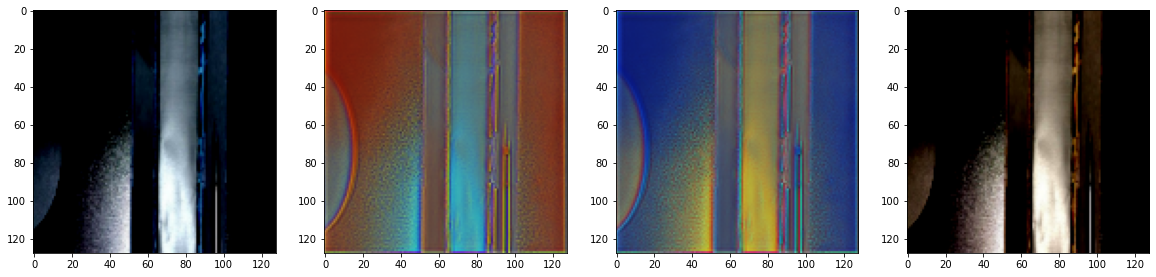

In [98]:
data = ZipFile("augmentation.zip", "r")

_, ax = plt.subplots(1, 4, figsize=(20, 8))

imgs_A = cycle_gan.data_loader.load_data(domain="0", batch_size=1, is_testing=True)
b, g, r = cv2.split(imgs_A.reshape((128, 128, 3)))
ax[3].imshow(imgs_A.reshape((128, 128, 3)))
imgs_A = cv2.merge((r, g, b))
ax[0].imshow(imgs_A)
imgs_A = imgs_A.reshape((-1, 128, 128, 3))

fake_B = (cycle_gan.g_AB.predict(imgs_A) * 0.5 + 0.5).reshape((128, 128, 3))
ax[1].imshow(fake_B)

b, g, r = cv2.split(fake_B)
ax[2].imshow(cv2.merge((r, g, b)))

data.close()